# Reducción de Dimensionalidad y Benchmarking de Modelos (Core)
Descripción:

En este proyecto, aplicarás una combinación de técnicas avanzadas, comenzando por un análisis de reducción de dimensionalidad (como PCA) y luego realizarás un benchmark de diferentes modelos de machine learning para encontrar el que mejor se adecue a los objetivos específicos del dataset que has elegido.



Objetivo:

El objetivo es realizar un análisis exhaustivo que comience con la reducción de dimensionalidad para simplificar el dataset y luego probar varios modelos de machine learning para determinar cuál ofrece el mejor rendimiento en términos de precisión, recall, F1-score u otras métricas relevantes para tu problema.

# 1. Selección del dataset:

* Utiliza el dataset que seleccionaste para el Proyecto 2 o elige uno adecuado de Kaggle que se relacione con tu área de interés. El dataset debe tener al menos 10 características y una variable objetivo clara.
* Realiza una exploración inicial para entender las variables y la relación que tienen con la variable objetivo.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score, precision_recall_fscore_support
from sklearn.model_selection import cross_val_predict, StratifiedKFold

In [20]:
# cargar el dataset
data = pd.read_csv('../data/water_potability.csv')
data

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
...,...,...,...,...,...,...,...,...,...,...
3271,4.668102,193.681735,47580.991603,7.166639,359.948574,526.424171,13.894419,66.687695,4.435821,1
3272,7.808856,193.553212,17329.802160,8.061362,NaN,392.449580,19.903225,NaN,2.798243,1
3273,9.419510,175.762646,33155.578218,7.350233,NaN,432.044783,11.039070,69.845400,3.298875,1
3274,5.126763,230.603758,11983.869376,6.303357,NaN,402.883113,11.168946,77.488213,4.708658,1


In [21]:
qsna=data.shape[0]-data.isnull().sum(axis=0)
qna=data.isnull().sum(axis=0)
ppna=round(100*(data.isnull().sum(axis=0)/data.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
Sulfate,2495,781,23.84
ph,2785,491,14.99
Trihalomethanes,3114,162,4.95
Hardness,3276,0,0.00
Solids,3276,0,0.00
Chloramines,3276,0,0.00
Conductivity,3276,0,0.00
Organic_carbon,3276,0,0.00
Turbidity,3276,0,0.00
Potability,3276,0,0.00


In [22]:
data.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [29]:
# como sulfate tiene una distribucion normal se decide imputar los NaN por la media en vez de eliminar y perder mucho datos
# Calcular la media de la columna 'Sulfate', ignorando los valores nulos
mean_sulfate = data['Sulfate'].mean()
mean_ph = data['ph'].mean()
median_trihalomethanes = data['Trihalomethanes'].median()

# Imputar los valores nulos con la media
data.fillna({'Sulfate': mean_sulfate}, inplace=True)
data.fillna({'ph': mean_ph}, inplace=True)
data.fillna({'Trihalomethanes': median_trihalomethanes}, inplace=True)

In [30]:
qsna=data.shape[0]-data.isnull().sum(axis=0)
qna=data.isnull().sum(axis=0)
ppna=round(100*(data.isnull().sum(axis=0)/data.shape[0]),2)
aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
na=pd.DataFrame(data=aux)
na.sort_values(by='Na en %',ascending=False)

,datos sin NAs en q,Na en q,Na en %
ph,3276,0,0.0
Hardness,3276,0,0.0
Solids,3276,0,0.0
Chloramines,3276,0,0.0
Sulfate,3276,0,0.0
Conductivity,3276,0,0.0
Organic_carbon,3276,0,0.0
Trihalomethanes,3276,0,0.0
Turbidity,3276,0,0.0
Potability,3276,0,0.0


# 2. Reducción de dimensionalidad:

* Implementa un análisis de reducción de dimensionalidad utilizando PCA (u otra técnica adecuada). El objetivo es reducir el número de características, manteniendo al menos el 80-90% de la variabilidad original.
* Visualiza los componentes principales y discute cómo contribuyen a la variabilidad del dataset.
* Utiliza las características reducidas para simplificar el conjunto de datos.

In [47]:
# Separar las características (X) y el target (y)
X = data.drop(columns=['Potability'])  # Variables predictoras
y = data['Potability']                 # Variable objetivo

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos (importante antes de PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

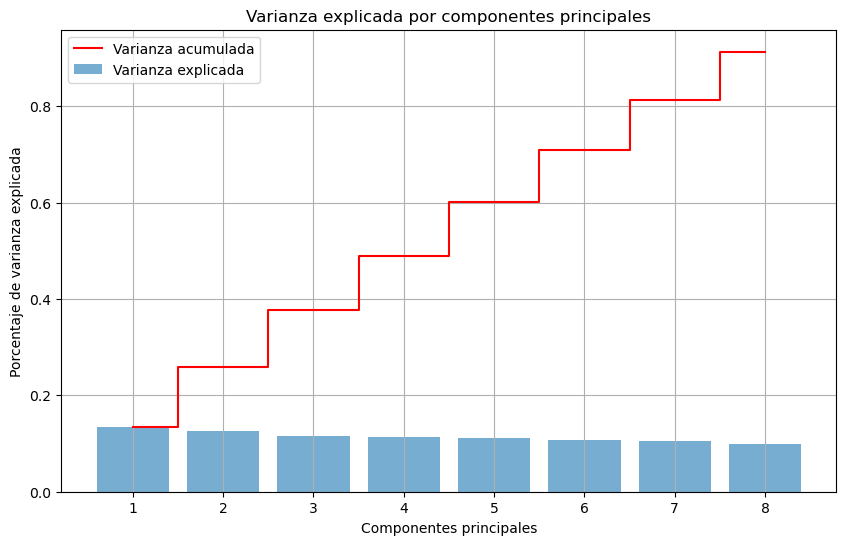

Número de componentes seleccionados: 8
Componente 1: 13.37%
Componente 2: 12.61%
Componente 3: 11.65%
Componente 4: 11.34%
Componente 5: 11.14%
Componente 6: 10.78%
Componente 7: 10.51%
Componente 8: 9.93%
Varianza total explicada: 91.33%


In [48]:
# Aplicar PCA solo al conjunto de entrenamiento
pca = PCA(n_components=0.9)  # Captura el 90% de la varianza
X_train_pca = pca.fit_transform(X_train_scaled)

# Obtener información de la varianza explicada
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Graficar la varianza acumulada y la varianza explicada por cada componente
plt.figure(figsize=(10, 6))

# Varianza explicada por cada componente
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.6, label='Varianza explicada')

# Varianza acumulada
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Varianza acumulada', color='red')

# Configurar el gráfico
plt.xlabel('Componentes principales')
plt.ylabel('Porcentaje de varianza explicada')
plt.title('Varianza explicada por componentes principales')
plt.xticks(range(1, len(explained_variance_ratio) + 1))
plt.legend(loc='best')
plt.grid()
plt.show()

# Imprimir información clave
print(f"Número de componentes seleccionados: {pca.n_components_}")
for i, var in enumerate(explained_variance_ratio, 1):
    print(f"Componente {i}: {var * 100:.2f}%")
print(f"Varianza total explicada: {cumulative_variance[-1] * 100:.2f}%")

# 3. Benchmarking de modelos:
* Implementa y compara al menos tres modelos de machine learning en el dataset reducido

## Random Forest, Xgboost y Arbol de desiciones

In [54]:
# Transformar el conjunto de prueba con los mismos parámetros de PCA
X_test_pca = pca.transform(X_test_scaled)

# Configurar validación cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Ajustar manualmente los parámetros para cada modelo
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=150,          # Número de árboles
        max_depth=15,              # Profundidad máxima
        min_samples_split=7,       # Mínimas muestras para dividir un nodo
        random_state=42
    ),
    "XGBoost": XGBClassifier(
        learning_rate=0.2,         # Tasa de aprendizaje
        n_estimators=200,          # Número de árboles
        max_depth=7,               # Profundidad máxima
        subsample=0.7,             # Fracción de datos para entrenar cada árbol
        use_label_encoder=False, 
        eval_metric='logloss',
        random_state=42
    ),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=15,              # Profundidad máxima
        min_samples_split=15,      # Mínimas muestras para dividir un nodo
        criterion='gini',          # Criterio de división
        random_state=42
    )
}

# Almacenar métricas
metrics = {}

In [55]:
# Paso 5: Evaluar cada modelo
for model_name, model in models.items():
    print(f"Evaluando: {model_name}")
    
    # Predicciones con validación cruzada usando el conjunto de entrenamiento reducido
    y_pred = cross_val_predict(model, X_train_pca, y_train, cv=skf, method='predict')
    y_pred_proba = cross_val_predict(model, X_train_pca, y_train, cv=skf, method='predict_proba')[:, 1]
    
    # Calcular métricas
    precision, recall, f1, _ = precision_recall_fscore_support(y_train, y_pred, average='binary')
    accuracy = accuracy_score(y_train, y_pred)
    auc = roc_auc_score(y_train, y_pred_proba)
    
    # Guardar métricas
    metrics[model_name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "AUC-ROC": auc
    }
    
    # Imprimir resultados
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1-Score: {f1:.2f}")
    print(f"AUC-ROC: {auc:.2f}")
    print("\n" + "-"*40 + "\n")

Evaluando: Random Forest
Accuracy: 0.65
Precision: 0.63
Recall: 0.28
F1-Score: 0.38
AUC-ROC: 0.65

----------------------------------------

Evaluando: XGBoost


c:\Users\IK\anaconda3\envs\ml_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:49:49] WARNING: D:\bld\xgboost-split_1732150467793\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\IK\anaconda3\envs\ml_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:49:50] WARNING: D:\bld\xgboost-split_1732150467793\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\IK\anaconda3\envs\ml_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:49:51] WARNING: D:\bld\xgboost-split_1732150467793\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\IK\anaconda3\envs\ml_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:49:52] WARNING: D:\bld\xgboost-split_1732150467793\work\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, U

Accuracy: 0.63
Precision: 0.53
Recall: 0.44
F1-Score: 0.48
AUC-ROC: 0.64

----------------------------------------

Evaluando: Decision Tree
Accuracy: 0.58
Precision: 0.46
Recall: 0.41
F1-Score: 0.44
AUC-ROC: 0.56

----------------------------------------



# 4. Análisis comparativo de modelos:

In [56]:
# Comparar métricas
print("\nComparación de métricas entre modelos:")
for model_name, metric in metrics.items():
    print(f"\n{model_name}:")
    for metric_name, value in metric.items():
        print(f"  {metric_name}: {value:.2f}")



Comparación de métricas entre modelos:

Random Forest:
  Accuracy: 0.65
  Precision: 0.63
  Recall: 0.28
  F1-Score: 0.38
  AUC-ROC: 0.65

XGBoost:
  Accuracy: 0.63
  Precision: 0.53
  Recall: 0.44
  F1-Score: 0.48
  AUC-ROC: 0.64

Decision Tree:
  Accuracy: 0.58
  Precision: 0.46
  Recall: 0.41
  F1-Score: 0.44
  AUC-ROC: 0.56


## Analisis
* Los 3 modelos tuvieron muy bajo desempeño, esto podria deberse a que los parametros necesitan ajustarse mejor pero eso tambien tendria un mayor costo computacional, tambien se podria aplicar gridsearchCV para ajustar los hiperparametros
* Otra razon podria deberse que ningun modelo es efectivo para este problema en especifico